In [46]:
import numpy as np
from mpmath import nsum, nprod, fac
from statistics import mean
import matplotlib.pyplot as plt

In [496]:
def print_parameters(p_denial, Q, A, avg_queue_length, avg_processing, average_requests_in_system, avg_processing_time,
                        avg_waiting_time, avg_total_time):
    print('\nDenial probability: ', p_denial)
    print('Relative volume: ', Q)
    print('Absolute volume', A)
    print('Average queue length: ', avg_queue_length)
    print('Average number of requests processed at one time: ', avg_processing)
    print('Average number of requests in system: ', average_requests_in_system)
    print('Average processing time: ', avg_processing_time)
    print('Average waiting time: ', avg_waiting_time)
    print('Average time in system: ', avg_total_time)

In [270]:
class RequestSubmit:
    def __init__(self, timepoint, type_of_request):
        self.timepoint = timepoint
        self.type_of_request = type_of_request

In [269]:
class RequestProcess:
    def __init__(self, start_timepoint, timepoint, terminal_no, type_of_request):
        self.start_timepoint = start_timepoint
        self.timepoint = timepoint
        self.terminal_no = terminal_no
        self.type_of_request = type_of_request

In [508]:
class CharacteristicsShower():
    def __init__(self, model):
        self.model = model
    
    def empirical(self):
        print('\nEmpirical characteristics:')
        
        print('Processed requests: ', self.model.requests_processed)
        print('Denied requests: ', self.model.requests_denied)

        avg_processing = 0
        probs = []
        for k in range(self.model.n + 1):
            pk = self.model.final_state_durations[k] / self.model.timeline[-1].timepoint
            probs.append(pk)
            avg_processing += k * pk
            print(f'Probability is equal to {pk} when {k} terminals are busy and 0 requests are in queue')

        avg_queue_length = 0
        for s in range(self.model.n + 1, self.model.n + self.model.m + 1):
            ps = self.model.final_state_durations[s] / self.model.timeline[-1].timepoint
            probs.append(ps)
            avg_queue_length += (s - self.model.n) * ps
            print(f'Probability is equal to {ps} when {self.model.n} terminals are busy and {s - self.model.n} requests are in queue')

        p_denial = ps
        Q = 1 - p_denial
        A = self.model.lambda_ * Q
        avg_waiting_time = mean(self.model.waiting_time)
        avg_processing_time = mean(self.model.processing_time)
        avg_total_time = avg_waiting_time + avg_processing_time

        print_parameters(p_denial, Q, A, avg_queue_length, avg_processing, avg_processing + avg_queue_length, avg_processing_time,
                            avg_waiting_time, avg_total_time)
        
        return probs
        
    def theoretical(self):
        print('\nTheoretical characteristics:')
        
        ro = self.model.lambda_ / self.model.mu
        p0 = 1 / (nsum(lambda k: ro ** k / fac(k), [0, self.model.n]) + (ro ** self.model.n / fac(self.model.n)) \
                  * nsum(lambda i: ro ** i / nprod(lambda l: (self.model.n + l * self.model.nu / self.model.mu), [1, i]), [1, self.model.m])) 
        print(f'Probability is equal to {p0} when 0 terminals are busy and 0 requests are in queue')

        avg_processing = 0
        probs = [p0]
        for k in range(1, self.model.n + 1):
            pk = ro ** k * p0 / fac(k)
            probs.append(pk)
            avg_processing += k * pk
            print(f'Probability is equal to {pk} when {k} terminals are busy and 0 requests are in queue')

        avg_queue_length = 0
        for s in range(1, self.model.m + 1):
            ps = ro ** (self.model.n + s) * p0 / (fac(self.model.n) * nprod(lambda l: self.model.n + l * self.model.nu / self.model.mu, [1, s]))
            probs.append(ps)
            avg_queue_length += s * ps
            print(f'Probability is equal to {ps} when {self.model.n} terminals are busy and {s} requests are in queue')

        p_denial = ps
        Q = 1 - p_denial
        A = self.model.lambda_ * Q
        avg_waiting_time = avg_queue_length / self.model.lambda_
        avg_processing_time = Q / self.model.mu
        avg_total_time = avg_processing_time + avg_waiting_time
        
        print_parameters(p_denial, Q, A, avg_queue_length, avg_processing, avg_processing + avg_queue_length, avg_processing_time,
                            avg_waiting_time, avg_total_time)
        
        return probs

    def show_stationary_stats(self):
        x = [timepoint for timepoint, _ in self.model.state_durations]

        for i in range(len(self.model.final_state_durations)):
            y = [durations[i] / timepoint for timepoint, durations in self.model.state_durations]
            plt.plot(x, y)

        plt.show()

    def plot_graphs(self):
        empirical_probs = self.empirical()
        theoretical_probs = self.theoretical()
        _, ax = plt.subplots(1, 2)
        ax[0].title.set_text('Empirical probabilities')
        ax[0].hist(list(np.arange(0, len(empirical_probs), 1)), weights=empirical_probs)
        ax[1].title.set_text('Theoretical probabilities')
        ax[1].hist(list(np.arange(0, len(theoretical_probs), 1)), weights=theoretical_probs)
        plt.show()

        self.show_stationary_stats()

In [436]:
class SystemOfMassServiceModel:
    def __init__(self, n, m, lambda_, mu, nu, max_requests, eps):
        self.n = n
        self.m = m
        self.lambda_ = lambda_
        self.mu = mu
        self.nu = nu
        self.max_requests = max_requests
        self.eps = eps
        
        self.terminal_availabilities = [True for _ in range(n)]
        self.timeline = []
        self.queue = []

        self.busy_terminals = 0
        self.state_durations = []
        self.final_state_durations = [0] * (n + m + 1)
        self.last_state = 0
        self.last_state_change_timepoint = 0

        self.requests_processed = 0
        self.requests_denied = 0

        self.processing_time = []
        self.waiting_time = []
        
        self.i = 0

    def modeling(self):
        requests, services, waitings = self.get_generated_values()

        self.timeline.append(RequestSubmit(requests[0], 'submitted'))

        self.add_submits_to_timeline(requests)
            
        for event in self.timeline:
            self.clean_queue(event.timepoint)

            if event.type_of_request == 'submitted':
                terminals_available, terminal_no = self.find_terminal()

                if terminals_available:
                    self.process_request(event, services, terminal_no)
                else:
                    self.add_to_queue_or_deny(event, waitings)
            else:
                self.free_terminals(event)

                if len(self.queue) != 0:
                    self.request_processing(event, services)

                self.record_state(event.timepoint)
                
    def add_submits_to_timeline(self, requests):
        for i in range(self.max_requests - 1):
            timepoint = self.timeline[len(self.timeline) - 1].timepoint + requests[i]
            self.timeline.append(RequestSubmit(timepoint, 'submitted'))
                
    def free_terminals(self, event):
        self.requests_processed += 1
        self.busy_terminals -= 1
        self.terminal_availabilities[event.terminal_no] = True
        self.processing_time.append(event.timepoint - event.start_timepoint)
                
    def add_to_queue_or_deny(self, event, waitings):
        if len(self.queue) < self.m:
            self.queue.append((event.timepoint,  event.timepoint + waitings[i]))
            self.record_state(event.timepoint)
        else:
            self.requests_denied += 1
                
    def process_request(self, event, services, terminal_no):
        self.insert(RequestProcess(event.timepoint, event.timepoint + services[i], terminal_no, 'processed'))
        self.record_state(event.timepoint)
        self.i += 1

    def insert(self, event):
        for i in range(1, len(self.timeline)):
            if event.timepoint > self.timeline[i - 1].timepoint and event.timepoint < self.timeline[i].timepoint:
                self.timeline.insert(i, event)
                break
        else:
            self.timeline.append(event)

    def find_terminal(self):
        for i, status in enumerate(self.terminal_availabilities):
            if status:
                self.busy_terminals += 1
                self.terminal_availabilities[i] = False

                return True, i
        
        return False, -1

    def clean_queue(self, current_timepoint):
        cleaned_queue = []

        while len(self.queue) != 0:
            start_timepoint, waiting_deadline = self.queue.pop(0)

            if current_timepoint > waiting_deadline:
                self.requests_denied += 1
                self.record_state(waiting_deadline)
            else:
                cleaned_queue.append((start_timepoint, waiting_deadline))

        self.queue = cleaned_queue
        
    def request_processing(self, event, services):
        start_timepoint, _ = self.queue.pop(0)
        request_processed_event = RequestProcess(event.timepoint, event.timepoint + services[i], 
                                                   event.terminal_no, 'processed')
        self.terminal_availabilities[event.terminal_no] = False
        self.busy_terminals += 1
        self.insert(request_processed_event)
        self.waiting_time.append(event.timepoint - start_timepoint)
                
    def record_state(self, timepoint):
        time_delta = timepoint - self.last_state_change_timepoint
        self.final_state_durations[self.last_state] += time_delta

        self.last_state_change_timepoint = timepoint
        self.last_state = self.busy_terminals + len(self.queue)

        self.state_durations.append((timepoint, self.final_state_durations.copy()))
        
    def get_generated_values(self):
        rng = np.random.default_rng() 
        requests = rng.exponential(1 / self.lambda_, self.max_requests)
        services = rng.exponential(1 / self.mu, self.max_requests)
        waitings = rng.exponential(1 / self.nu, self.max_requests)
        return requests, services, waitings

MODELING WITH THE NEXT PARAMETERS: n = 2, m = 3, lambda = 2, mu = 3, nu = 1

Empirical characteristics:
Processed requests:  894
Denied requests:  106
Probability is equal to 0.43326257724856726 when 0 terminals are busy and 0 requests are in queue
Probability is equal to 0.3732116459581585 when 1 terminals are busy and 0 requests are in queue
Probability is equal to 0.15795340827482116 when 2 terminals are busy and 0 requests are in queue
Probability is equal to 0.03124660601206257 when 2 terminals are busy and 1 requests are in queue
Probability is equal to 0.004036211219641785 when 2 terminals are busy and 2 requests are in queue
Probability is equal to 0.0002895512867486829 when 2 terminals are busy and 3 requests are in queue

Denial probability:  0.0002895512867486829
Relative volume:  0.9997104487132513
Absolute volume 1.9994208974265026
Average queue length:  0.05457892634534623
Average number of requests processed at one time:  0.553415253613
Average number of requests in syst

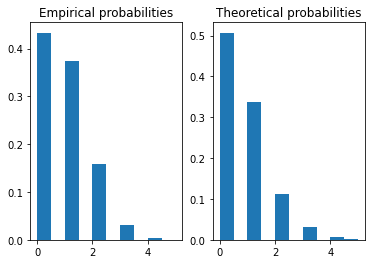

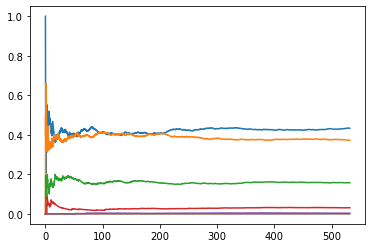

In [498]:
params = (2, 3, 2, 3, 1, 1000, 0.05)
model = SystemOfMassServiceModel(*params)
model.modeling()
print(f'MODELING WITH THE NEXT PARAMETERS: n = {model.n}, m = {model.m}, lambda = {model.lambda_}, mu = {model.mu}, nu = {model.nu}')
model_characteristics = CharacteristicsShower(model)
model_characteristics.plot_graphs()

MODELING WITH THE NEXT PARAMETERS: n = 2, m = 4, lambda = 1, mu = 3, nu = 1

Empirical characteristics:
Processed requests:  997
Denied requests:  3
Probability is equal to 0.47164381211690026 when 0 terminals are busy and 0 requests are in queue
Probability is equal to 0.35306279263439744 when 1 terminals are busy and 0 requests are in queue
Probability is equal to 0.12595622535765646 when 2 terminals are busy and 0 requests are in queue
Probability is equal to 0.039229059962927915 when 2 terminals are busy and 1 requests are in queue
Probability is equal to 0.008291717328082295 when 2 terminals are busy and 2 requests are in queue
Probability is equal to 0.0013780717869877402 when 2 terminals are busy and 3 requests are in queue
Probability is equal to 0.00043832081304783855 when 2 terminals are busy and 4 requests are in queue

Denial probability:  0.00043832081304783855
Relative volume:  0.9995616791869522
Absolute volume 0.9995616791869522
Average queue length:  0.00744509874512
A

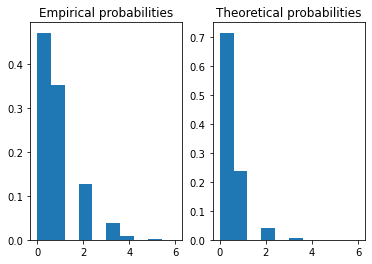

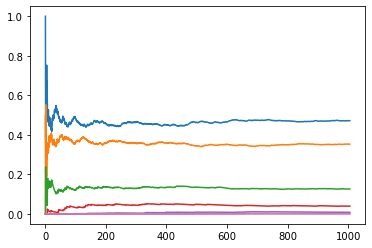

In [507]:
params = (2, 4, 1, 3, 1, 1000, 0.05)
model = SystemOfMassServiceModel(*params)
model.modeling()
print(f'MODELING WITH THE NEXT PARAMETERS: n = {model.n}, m = {model.m}, lambda = {model.lambda_}, mu = {model.mu}, nu = {model.nu}')
model_characteristics = CharacteristicsShower(model)
model_characteristics.plot_graphs()